# Hands-on Day 3

## You'll learn

### ML methods

- Multilayer Perceptron Classifier (MCP) with sklearn

### ML techniques
- hyperparameter optimisation
- ROC curves

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [1]:
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [3]:
#inputFile = 'file:///home/jovyan/Higgs100k.parquet'
inputFile = 'file:///home/jovyan/Higgs1M.parquet'
#inputFile = 'file:///home/jovyan/Higgs10M.parquet'

# read in input parquet file
%time df = pd.read_parquet(inputFile)

CPU times: user 935 ms, sys: 1.3 s, total: 2.23 s
Wall time: 374 ms


In [4]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

999999

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

999999
999999


# ML model

## Exercise 1

- Implement a shallow NN (MultiLayerPerceptronClassifier) with sklearn
- implement a network with: 
  - one input layer of size 28 (our features), 
  - two intermediate layers of size 30,
  - one output of size 2 (the label classes)
- plot the various metrics (ROC, signal vs background)
- bonus: do hyperparameter optimisation

In [7]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP classifier with two hidden layers of 30 neurons each
# takes 3 minutes on 100k evts, 30 minutes on 1M evts
mlp = MLPClassifier(hidden_layer_sizes=(30, 30), max_iter=1000, random_state=42)

# Train the model
%time mlp.fit(x_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(x_test)

CPU times: user 21min 40s, sys: 2.72 s, total: 21min 42s
Wall time: 21min 45s


In [8]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7433
Precision: 0.7506
Recall: 0.7699
F1-Score: 0.7601


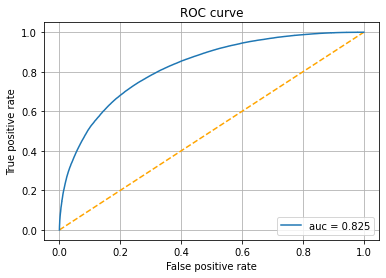

In [9]:
# Get predicted probabilities for the positive class
y_scores = mlp.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

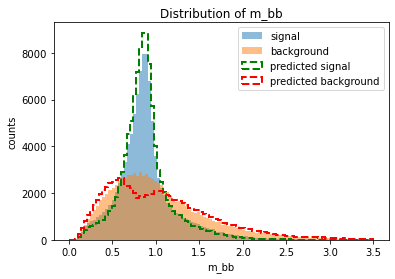

In [10]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

# Hyperparameter scan

In [11]:
# read in input parquet file
inputFile = 'file:///home/jovyan/Higgs100k.parquet'

%time df = pd.read_parquet(inputFile)

#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

CPU times: user 233 ms, sys: 178 ms, total: 411 ms
Wall time: 76.6 ms


99999

In [12]:
# Get the default hyperparameters
default_params = mlp.get_params()

# Print the default hyperparameters
for param, value in default_params.items():
    print(f"{param}: {value}")

activation: relu
alpha: 0.0001
batch_size: auto
beta_1: 0.9
beta_2: 0.999
early_stopping: False
epsilon: 1e-08
hidden_layer_sizes: (30, 30)
learning_rate: constant
learning_rate_init: 0.001
max_fun: 15000
max_iter: 1000
momentum: 0.9
n_iter_no_change: 10
nesterovs_momentum: True
power_t: 0.5
random_state: 42
shuffle: True
solver: adam
tol: 0.0001
validation_fraction: 0.1
verbose: False
warm_start: False


## Exercise 2

- do hyperparameter optimisation on 100k evts using Randomized Grid search
- select a reasonable number and range of hyperparameters
- do NOT USE all possible cores (check sklearn doc)
- while the code runs, check with top that there are indeed several python processes running
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [13]:
NJOBS = 5

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'hidden_layer_sizes': [(30, 30), (50, 50), (100,)],
    'learning_rate_init': uniform(0.001, 0.1),  # Samples values between 0.001 and 0.101
    'alpha': uniform(0.0001, 0.01),
    'activation': ['tanh', 'relu'],
}

# Randomized search with 20 random combinations
%time random_search = RandomizedSearchCV(estimator=mlp, param_distributions=param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=NJOBS, random_state=42)

# Fit the random search
random_search.fit(x_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Score: {:.4f}".format(random_search.best_score_))

CPU times: user 122 µs, sys: 0 ns, total: 122 µs
Wall time: 143 µs
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.003954165025399161, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01076721140063839}
Best Cross-Validation Score: 0.7092


In [14]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy: {:.4f}".format(test_accuracy))

Test Set Accuracy: 0.7147


In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7147
Precision: 0.7076
Recall: 0.7902
F1-Score: 0.7466


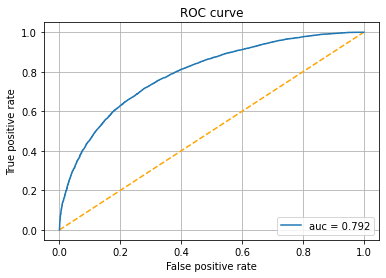

In [16]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

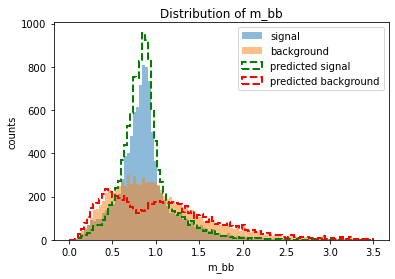

In [17]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

# Now train the best model

In [18]:
# read in input parquet file
inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

CPU times: user 6.9 s, sys: 12.4 s, total: 19.3 s
Wall time: 801 ms


10000000

In [ ]:
# Initialize the MLP classifier with two hidden layers of 30 neurons each
# takes 3 minutes on 100k evts, 30 minutes on 1M evts
best_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)

# Train the model
%time best_mlp.fit(x_train, y_train)

# Make predictions on the test set
y_pred = best_mlp.predict(x_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

In [ ]:
# Get predicted probabilities for the positive class
y_scores = best_mlp.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

In [ ]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)